### Goal
Predict if a passenger survived the sinking of the Titanic or not. 
For each in the test set, you must predict a 0 or 1 value for the variable.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb


### Data Pre-processing

In [4]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gender_data = pd.read_csv("gender_submission.csv")
gender_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
# Basic statistics of the training data
train_description = train_data.describe(include='all')

# Identify missing values in each column
missing_values = train_data.isnull().sum()
train_description, missing_values

(        PassengerId    Survived      Pclass                     Name   Sex  \
 count    891.000000  891.000000  891.000000                      891   891   
 unique          NaN         NaN         NaN                      891     2   
 top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
 freq            NaN         NaN         NaN                        1   577   
 mean     446.000000    0.383838    2.308642                      NaN   NaN   
 std      257.353842    0.486592    0.836071                      NaN   NaN   
 min        1.000000    0.000000    1.000000                      NaN   NaN   
 25%      223.500000    0.000000    2.000000                      NaN   NaN   
 50%      446.000000    0.000000    3.000000                      NaN   NaN   
 75%      668.500000    1.000000    3.000000                      NaN   NaN   
 max      891.000000    1.000000    3.000000                      NaN   NaN   
 
                Age       SibSp       Parch  Ticke

#### Handling missing data

In [8]:
# Calculate the overall median for Age
overall_median_age = train_data['Age'].median()

# Calculate the median age based on Pclass and Sex
median_age_by_group = train_data.groupby(['Pclass', 'Sex'])['Age'].median().unstack()
overall_median_age, median_age_by_group

(28.0,
 Sex     female  male
 Pclass              
 1         35.0  40.0
 2         28.0  30.0
 3         21.5  25.0)

In [9]:
# Impute missing Age values based on Pclass and Sex
for index, row in train_data[train_data['Age'].isnull()].iterrows():
    train_data.at[index, 'Age'] = median_age_by_group.loc[row['Pclass'], row['Sex']]

# Check if all missing values in Age column have been imputed
missing_age_after_imputation = train_data['Age'].isnull().sum()
missing_age_after_imputation

0

In [10]:
# Create a new binary feature 'HasCabin' indicating whether the cabin information is known or not
train_data['HasCabin'] = train_data['Cabin'].notna().astype(int)

# Impute missing values in 'Embarked' with the mode
most_frequent_embarked = train_data['Embarked'].mode()[0]
train_data['Embarked'].fillna(most_frequent_embarked, inplace=True)

# Check if all missing values in Cabin and Embarked columns have been handled
missing_cabin_after_imputation = train_data['Cabin'].isnull().sum()
missing_embarked_after_imputation = train_data['Embarked'].isnull().sum()

missing_cabin_after_imputation, missing_embarked_after_imputation

(687, 0)

The Cabin column still has 687 missing values.

#### Feature representing

In [11]:
# Title Extraction
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Grouping some less common titles under a common label "Other"
less_common_titles = ['Dr', 'Rev', 'Major', 'Col', 'Mlle', 'Don', 'Jonkheer', 'Lady', 'Countess', 'Ms', 'Mme', 'Sir', 'Capt']
train_data['Title'] = train_data['Title'].replace(less_common_titles, 'Other')

# Family Size
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1  # Adding 1 to account for the passenger themselves

# IsAlone
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1

# Fare per Person
train_data['FarePerPerson'] = train_data['Fare'] / train_data['FamilySize']

# Display the first few rows with the newly created features
train_data[['Name', 'Title', 'FamilySize', 'IsAlone', 'Fare', 'FarePerPerson']].head()

,Name,Title,FamilySize,IsAlone,Fare,FarePerPerson
0,"Braund, Mr. Owen Harris",Mr,2,0,7.2500,3.62500
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,2,0,71.2833,35.64165
2,"Heikkinen, Miss. Laina",Miss,1,1,7.9250,7.92500
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,2,0,53.1000,26.55000
4,"Allen, Mr. William Henry",Mr,1,1,8.0500,8.05000


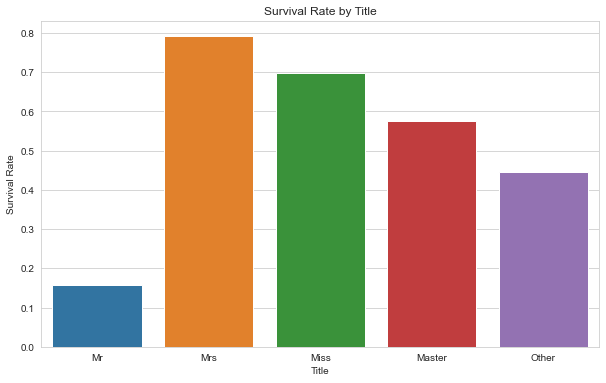

In [12]:
sns.set_style("whitegrid")

# Title vs. Survival
plt.figure(figsize=(10, 6))
sns.barplot(x='Title', y='Survived', data=train_data, ci=None)
plt.title("Survival Rate by Title")
plt.ylabel("Survival Rate")
plt.show()

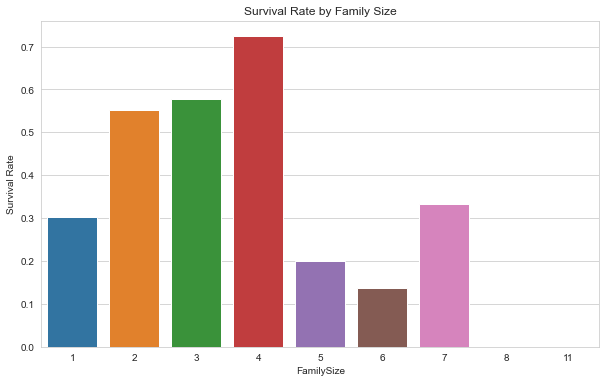

In [13]:
# FamilySize vs. Survival
plt.figure(figsize=(10, 6))
sns.barplot(x='FamilySize', y='Survived', data=train_data, ci=None)
plt.title("Survival Rate by Family Size")
plt.ylabel("Survival Rate")
plt.show()

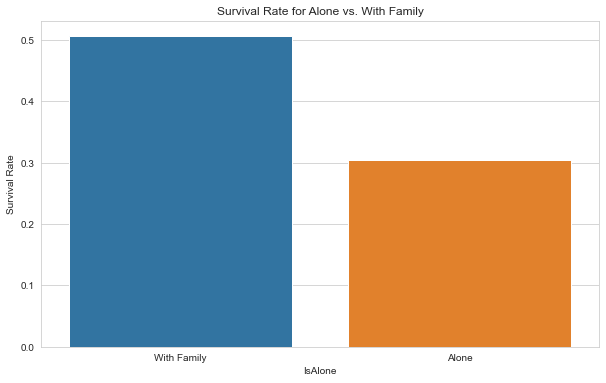

In [14]:
# IsAlone vs. Survival
plt.figure(figsize=(10, 6))
sns.barplot(x='IsAlone', y='Survived', data=train_data, ci=None)
plt.title("Survival Rate for Alone vs. With Family")
plt.xticks(ticks=[0, 1], labels=["With Family", "Alone"])
plt.ylabel("Survival Rate")
plt.show()

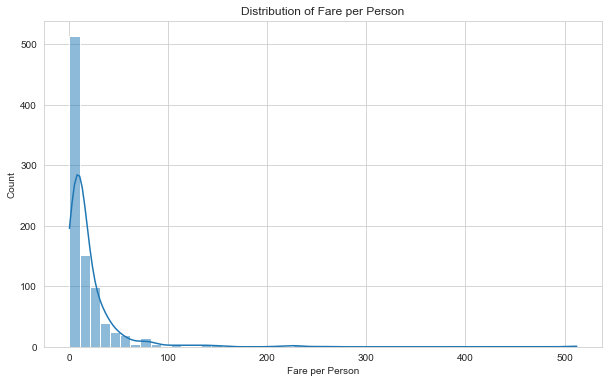

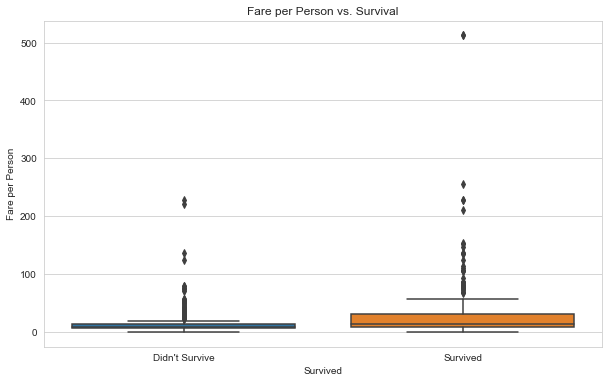

In [15]:
# FarePerPerson Distribution & Correlation with Survival
plt.figure(figsize=(10, 6))
sns.histplot(train_data['FarePerPerson'], kde=True, bins=50)
plt.title("Distribution of Fare per Person")
plt.xlabel("Fare per Person")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='FarePerPerson', data=train_data)
plt.title("Fare per Person vs. Survival")
plt.ylabel("Fare per Person")
plt.xlabel("Survived")
plt.xticks(ticks=[0, 1], labels=["Didn't Survive", "Survived"])
plt.show()

### Modeling

#### Data Pre-processing for modeling

In [16]:
# Encoding Categorical Variables
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

scaler = StandardScaler()
columns_to_scale = ['Age', 'Fare', 'FarePerPerson', 'FamilySize']
train_data[columns_to_scale] = scaler.fit_transform(train_data[columns_to_scale])

# Dropping Unnecessary Columns
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_data = train_data.drop(columns=drop_columns)
train_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,FamilySize,IsAlone,FarePerPerson,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,3,-0.534891,1,0,-0.502445,0,0.059160,0,-0.454798,1,0,1,0,1,0,0
1,1,1,0.668392,1,0,0.786845,1,0.059160,0,0.438994,0,0,0,0,0,1,0
2,1,3,-0.234070,0,0,-0.488854,0,-0.560975,1,-0.334757,0,0,1,1,0,0,0
3,1,1,0.442776,1,0,0.420730,1,0.059160,0,0.185187,0,0,1,0,0,1,0
4,0,3,0.442776,0,0,-0.486337,0,-0.560975,1,-0.331267,1,0,1,0,1,0,0


In [17]:
# Splitting the data into training and validation sets
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression model

In [18]:
# Initialize and train the Logistic Regression model
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = logreg.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred)
print(accuracy)

0.8156424581005587


In [19]:
classification_rep = classification_report(y_val, y_val_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       105
           1       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



#### Model testing

In [20]:
# Identify columns with missing values in the test dataset
missing_values_test = test_data.isnull().sum()
columns_with_missing_values = missing_values_test[missing_values_test > 0]

columns_with_missing_values

Age       86
Fare       1
Cabin    327
dtype: int64

In [21]:
# Impute missing Age values based on Pclass and Sex
for index, row in test_data[test_data['Age'].isnull()].iterrows():
    test_data.at[index, 'Age'] = median_age_by_group.loc[row['Pclass'], row['Sex']]

# Impute missing Fare values using median from training data
test_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)

# Apply the remaining preprocessing and feature engineering steps
test_data['HasCabin'] = test_data['Cabin'].notna().astype(int)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Title'].replace(less_common_titles, 'Other')
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['IsAlone'] = 0
test_data.loc[test_data['FamilySize'] == 1, 'IsAlone'] = 1
test_data['FarePerPerson'] = test_data['Fare'] / test_data['FamilySize']
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
test_data[columns_to_scale] = scaler.transform(test_data[columns_to_scale])
test_data = test_data.drop(columns=drop_columns)
missing_cols = set(X_train.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data = test_data[X_train.columns]

In [22]:
# Verify if any missing values
remaining_missing_values = test_data.isnull().sum().sum()

no_missing_values = remaining_missing_values == 0
no_missing_values

True

In [23]:
# Make predictions
predictions = logreg.predict(test_data)
remaining_missing_values, predictions[:10]  

(0, array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0]))

#### Model's confidence

In [24]:
samples_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Probability
probabilities = logreg.predict_proba(test_data.iloc[samples_indices])

# Extracting class 1 (Survived)
confidence_survived = probabilities[:, 1]
confidence_survived

array([0.09349547, 0.65718647, 0.08426033, 0.09372706, 0.73925827,
       0.13332964, 0.61098001, 0.10898914, 0.8949346 , 0.05920827])

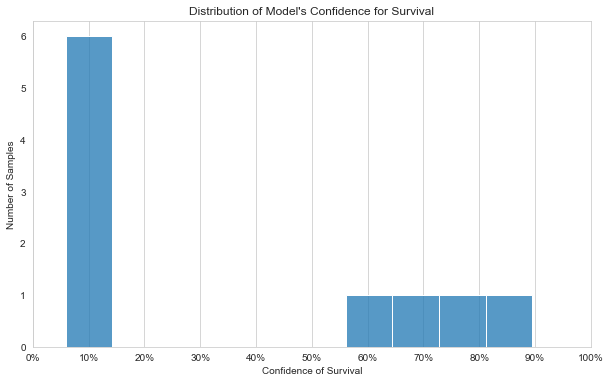

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(confidence_survived, bins=10, kde=False)
plt.title("Distribution of Model's Confidence for Survival")
plt.xlabel("Confidence of Survival")
plt.ylabel("Number of Samples")
plt.xlim(0, 1)
plt.xticks(ticks=[i/10 for i in range(11)], labels=['{}%'.format(i*10) for i in range(11)])
plt.grid(axis='y')
plt.show()

These probabilities give a clearer picture of how certain or uncertain the model is about its predictions. For instance, for the ninth sample, the model is very confident (
89.49%) that the passenger survived, whereas for the tenth sample, it's quite sure (
5.92%) that the passenger did not survive.

#### Feature Importance

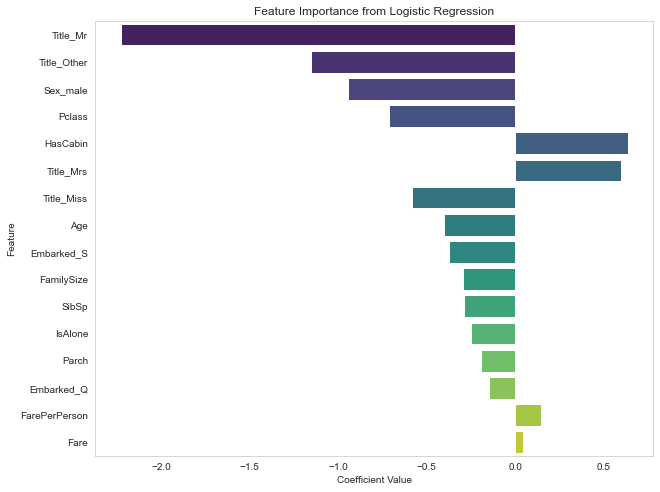

In [26]:
# Coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': logreg.coef_[0]
})

# Sorting the features
feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance from Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.show()

Gender (Sex_male) is a significant predictor, with males being less likely to survive than females.
Titles play a crucial role, with "Mrs." and "Miss." indicating higher chances of survival, while "Mr." indicates lower chances.
Age also plays a role, with younger passengers having a higher likelihood of survival.

### Random Forest Classifier

In [27]:
# Initialize and train the Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = random_forest.predict(X_val)

# Calculate the accuracy and other metrics for Random Forest
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
accuracy_rf 

0.8435754189944135

In [28]:
classification_rep_rf = classification_report(y_val, y_val_pred_rf)
print(classification_rep_rf)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       105
           1       0.79      0.84      0.82        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.84      0.84       179



The Random Forest Classifier has a slightly higher accuracy than the Logistic Regression model on the validation set. 

#### Random forest testing

In [29]:
# Identify missing columns in test_data that are present in X_train
missing_cols_test = set(X_train.columns) - set(test_data.columns)

# Add missing columns to the test dataset and set their values to 0
for col in missing_cols_test:
    test_data[col] = 0

# Ensure the test_data has the same column order as X_train
test_data = test_data[X_train.columns]

# Make predictions on the test dataset using the previously trained Random Forest model
predictions_rf = random_forest.predict(test_data)

# Display the first 10 predictions
print(predictions_rf[:10])


[0 0 0 1 0 0 0 0 1 0]


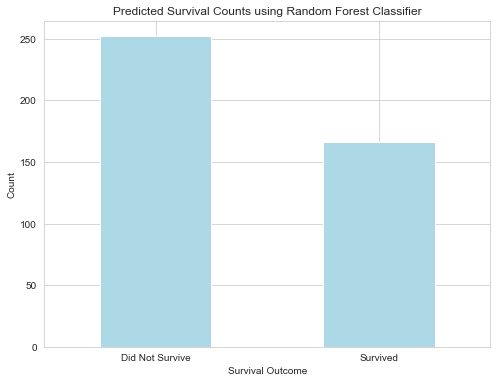

In [30]:
survivor_counts = pd.Series(predictions_rf).value_counts().sort_index()

plt.figure(figsize=(8, 6))
survivor_counts.plot(kind='bar', color=['lightblue'], rot=0)
plt.title('Predicted Survival Counts using Random Forest Classifier')
plt.xlabel('Survival Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Did Not Survive', 'Survived'])
plt.show()

#### Tune the Random Forest model

In [31]:
# Default hyperparameters
default_random_forest = RandomForestClassifier(random_state=42)
default_random_forest.fit(X_train, y_train)

# Predict on validation set
y_val_pred_default_rf = default_random_forest.predict(X_val)

# Calculate the accuracy and metrics
accuracy_default_rf = accuracy_score(y_val, y_val_pred_default_rf)
accuracy_default_rf

0.8435754189944135

In [32]:
classification_rep_default_rf = classification_report(y_val, y_val_pred_default_rf)
print(classification_rep_default_rf)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       105
           1       0.79      0.84      0.82        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.84      0.84       179



There is no difference using defult hyperparameters for Random Forest Classifier, so i decided to use another hyperparameter. 

#### Grid search

In [33]:
# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

The grid search evaluated 216 different hyperparameter combinations. Given that 1080 models were trained, the process can be computationally intensive and time-consuming. Also, the model used 5-fold cross-validation provides a more robust assessment of model performance.

The combined values is expecting the best model performance during the grid search.

### Gradient Boosted Trees (GBT) with default parameters

In [34]:
# Train the Gradient Boosted Trees model with default parameters
gbt_default = GradientBoostingClassifier(random_state=42)
gbt_default.fit(X_train, y_train)

# Evaluate the GBT model on the validation set
accuracy_gbt_default = gbt_default.score(X_val, y_val)
print(accuracy_gbt_default)

0.8324022346368715


#### How to train a GBT with improved default parameters: Using Random Search

In [35]:
# Initialize XGBoost classifier with improved default parameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)

# Evaluate the model's performance using 2-fold cross-validation
cross_val_scores = cross_val_score(xgb_clf, X, y, cv=2, scoring='accuracy')

/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [36]:
cross_val_scores_mean = cross_val_scores.mean()
print(cross_val_scores_mean)

0.8114475739406459


In [37]:
cross_val_scores_std = cross_val_scores.std()
print(cross_val_scores_std)

0.00021161888446619148


The Gradient Boosted Trees model performed with an average accuracy of approximately 81.14% across the 2-fold cross-validation. This accuracy was consistently achieved across both folds, as indicated by the very low standard deviation of 0.02116%. This suggests that the model is both effective and stable in its predictions for this dataset.

#### How to tune the parameters of a GBTs

In [38]:
# Define the distributions for hyperparameters
param_distributions = {
    'max_depth': np.arange(3, 8),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'n_estimators': np.arange(50, 501, 50),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X, y)

# Get the best parameters and best score from random search
best_params_random = random_search.best_params_
print(best_params_random)


/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
{'subsample': 0.6, 'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 0.5}


In [39]:
best_score_random = random_search.best_score_
print(best_score_random)

0.814820879729934


With these hyperparameters, the model achieved an average accuracy of 
83.28% over 2-fold cross-validation.

#### How to train and ensemble many GBTs

In [40]:
# Define three GBT models with varying hyperparameters
gbt1 = xgb.XGBClassifier(learning_rate=0.05, n_estimators=100, max_depth=3, use_label_encoder=False, random_state=42)
gbt2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, use_label_encoder=False, random_state=42)
gbt3 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, use_label_encoder=False, random_state=42)

# Ensemble the GBTs using a majority voting strategy
ensemble_model = VotingClassifier(estimators=[('gbt1', gbt1), ('gbt2', gbt2), ('gbt3', gbt3)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model on the validation set
ensemble_val_predictions = ensemble_model.predict(X_val)
ensemble_val_accuracy = accuracy_score(y_val, ensemble_val_predictions)

print(ensemble_val_accuracy)

/Users/carolchen/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.8212290502793296


An accuracy of 
0.8212
on the validation set using the ensemble of GBTs is a good result, especially considering it's an improvement over using a single GBT.

#### GBT Testing

In [41]:
# Split the data again into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify missing columns in test_data that are present in X_train
missing_cols_test = set(X_train.columns) - set(test_data.columns)

# Add missing columns to the test dataset and set their values to 0
for col in missing_cols_test:
    test_data[col] = 0

# Ensure the test_data has the same column order as X_train
test_data = test_data[X_train.columns]

# Make predictions on the test dataset using the ensemble model
predictions_ensemble = ensemble_model.predict(test_data)

# Display the first 10 predictions
predictions_ensemble[:10]


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

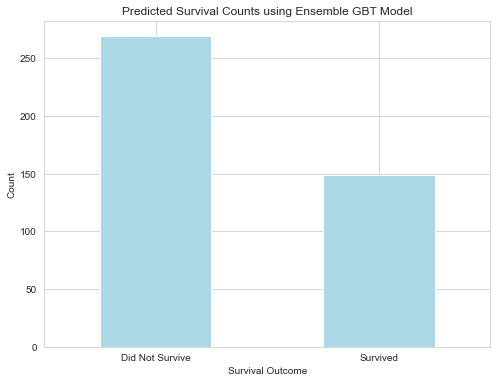

In [42]:
survivor_counts = pd.Series(predictions_ensemble).value_counts().sort_index()

plt.figure(figsize=(8, 6))
survivor_counts.plot(kind='bar', color=['lightblue'], rot=0)
plt.title('Predicted Survival Counts using Ensemble GBT Model')
plt.xlabel('Survival Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Did Not Survive', 'Survived'])
plt.show()

In [47]:
test_data = pd.read_csv("test.csv")

# Create a submission DataFrame with PassengerId and the predicted Survived status
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions_ensemble
})

# Save the submission DataFrame to a CSV file
submission_file_path = "submission.csv"
submission.to_csv(submission_file_path, index=False)

submission_file_path

'submission.csv'